In [78]:
# imports
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import collections
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics

In [2]:
vehicles = pd.read_csv('../data/Motor_Vehicle_Collisions_-_Vehicles_20241103.csv', index_col=0, low_memory=False)
# vehicles

In [3]:
# set(vehicles["CONTRIBUTING_FACTOR_1"])
print(vehicles.head)

<bound method NDFrame.head of            COLLISION_ID  CRASH_DATE CRASH_TIME  \
UNIQUE_ID                                        
10385780         100201  09/07/2012       9:03   
19140702        4213082  09/23/2019       8:15   
14887647        3307608  10/02/2015      17:18   
14889754        3308693  10/04/2015      20:34   
14400270         297666  04/25/2013      21:15   
...                 ...         ...        ...   
20774561        4767779  10/27/2024      15:16   
20774656        4767855  10/28/2024       7:45   
20773672        4767169  10/29/2024       4:25   
20774412        4767800  10/24/2024      14:42   
20774394        4767691  10/28/2024       8:37   

                                     VEHICLE_ID STATE_REGISTRATION  \
UNIQUE_ID                                                            
10385780                                      1                 NY   
19140702   0553ab4d-9500-4cba-8d98-f4d7f89d5856                 NY   
14887647                               

In [4]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
print(f'Raw vehicles rows: {vehicles.size:,}' )
print(vehicles.iloc[0])

Raw vehicles rows: 102,665,184
COLLISION_ID                              100201
CRASH_DATE                            09/07/2012
CRASH_TIME                                  9:03
VEHICLE_ID                                     1
STATE_REGISTRATION                            NY
VEHICLE_TYPE                   PASSENGER VEHICLE
VEHICLE_MAKE                                 NaN
VEHICLE_MODEL                                NaN
VEHICLE_YEAR                                 NaN
TRAVEL_DIRECTION                             NaN
VEHICLE_OCCUPANTS                            NaN
DRIVER_SEX                                   NaN
DRIVER_LICENSE_STATUS                        NaN
DRIVER_LICENSE_JURISDICTION                  NaN
PRE_CRASH                                    NaN
POINT_OF_IMPACT                              NaN
VEHICLE_DAMAGE                               NaN
VEHICLE_DAMAGE_1                             NaN
VEHICLE_DAMAGE_2                             NaN
VEHICLE_DAMAGE_3                      

In [5]:
# filter by date 
cutoff_date = datetime.now() - timedelta(days=10*365)
cutoff_year = datetime.today().year + 2
vehicles['CRASH_DATE'] = pd.to_datetime(vehicles['CRASH_DATE'], format='%m/%d/%Y')
filtered_vehicles = vehicles[(vehicles['CRASH_DATE'] >= cutoff_date)
    & (vehicles['VEHICLE_YEAR'] >= 1970)
    & (vehicles['VEHICLE_YEAR'] <= cutoff_year)
    & (vehicles['STATE_REGISTRATION'] != 'ZZ')]
print(f'Filtered vehicles size: {filtered_vehicles.size:,}')
print(f'Raw vehicles size: {vehicles.size:,}')

Filtered vehicles size: 56,342,304
Raw vehicles size: 102,665,184


In [6]:
print(filtered_vehicles["VEHICLE_YEAR"].unique())

[2002. 2015. 2006. 2005. 2013. 2018. 1990. 2007. 2011. 2008. 2019. 2017.
 2003. 2000. 2014. 2010. 2016. 2004. 2012. 2001. 1999. 1993. 1994. 2009.
 2020. 1998. 1989. 1995. 1986. 1997. 1985. 1992. 1996. 1988. 1991. 2021.
 2023. 1971. 2022. 1982. 1979. 1987. 1970. 2024. 1975. 1981. 1983. 1980.
 1984. 1973. 1972. 1978. 1977. 1976. 1974. 2026. 2025.]


In [7]:
print(filtered_vehicles.iloc[0])

COLLISION_ID                                                4213082
CRASH_DATE                                      2019-09-23 00:00:00
CRASH_TIME                                                     8:15
VEHICLE_ID                     0553ab4d-9500-4cba-8d98-f4d7f89d5856
STATE_REGISTRATION                                               NY
VEHICLE_TYPE                    Station Wagon/Sport Utility Vehicle
VEHICLE_MAKE                                          TOYT -CAR/SUV
VEHICLE_MODEL                                                   NaN
VEHICLE_YEAR                                                 2002.0
TRAVEL_DIRECTION                                              North
VEHICLE_OCCUPANTS                                               1.0
DRIVER_SEX                                                        M
DRIVER_LICENSE_STATUS                                      Licensed
DRIVER_LICENSE_JURISDICTION                                      NY
PRE_CRASH                                      G

In [8]:
copy_vehicles = filtered_vehicles.copy()
# copy_vehicles
# copy_vehicles = filtered_vehicles

In [9]:
copy_vehicles.columns

Index(['COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID',
       'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 'DRIVER_SEX',
       'DRIVER_LICENSE_STATUS', 'DRIVER_LICENSE_JURISDICTION', 'PRE_CRASH',
       'POINT_OF_IMPACT', 'VEHICLE_DAMAGE', 'VEHICLE_DAMAGE_1',
       'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE',
       'PUBLIC_PROPERTY_DAMAGE_TYPE', 'CONTRIBUTING_FACTOR_1',
       'CONTRIBUTING_FACTOR_2'],
      dtype='object')

#### ** TODO: **
Clean up columns
* Separate CRASH_DATE into 3 date fields, year, month day ✔
* Find out if date is a holiday?
* TRAVEL_DIRECTION ✔
* CONTRIBUTING_FACTOR_1, 2
* STATE_REGISTRATION ✔
* VEHICLE_DAMAGE, (20 features), maybe add  _1, _2, _3

In [10]:
copy_vehicles["TRAVEL_DIRECTION"] = copy_vehicles["TRAVEL_DIRECTION"].replace('E', "East").replace('N', "North").replace('S', 'South').replace('W', 'West').replace('U', 'Unknown').replace('-', 'Unknown')
copy_vehicles["TRAVEL_DIRECTION"]= copy_vehicles["TRAVEL_DIRECTION"].fillna('Unknown')

In [11]:
set(copy_vehicles["TRAVEL_DIRECTION"])

{'East',
 'North',
 'Northeast',
 'Northwest',
 'South',
 'Southeast',
 'Southwest',
 'Unknown',
 'West'}

In [12]:
for col in copy_vehicles.columns:
    print(col)
    print(copy_vehicles[col].unique())

COLLISION_ID
[4213082 3434155 4229067 ... 4767444 4767855 4767800]
CRASH_DATE
<DatetimeArray>
['2019-09-23 00:00:00', '2016-05-02 00:00:00', '2019-10-24 00:00:00',
 '2016-08-18 00:00:00', '2016-07-22 00:00:00', '2016-08-13 00:00:00',
 '2019-10-21 00:00:00', '2016-09-08 00:00:00', '2016-04-01 00:00:00',
 '2016-10-17 00:00:00',
 ...
 '2024-10-11 00:00:00', '2024-08-05 00:00:00', '2024-08-12 00:00:00',
 '2024-09-22 00:00:00', '2024-09-24 00:00:00', '2024-10-20 00:00:00',
 '2024-10-26 00:00:00', '2024-10-28 00:00:00', '2024-10-27 00:00:00',
 '2024-10-29 00:00:00']
Length: 3335, dtype: datetime64[ns]
CRASH_TIME
['8:15' '17:35' '13:15' ... '2:56' '3:13' '4:51']
VEHICLE_ID
['0553ab4d-9500-4cba-8d98-f4d7f89d5856' '219456'
 'c53b43d9-419a-4ab1-9361-3f2979078d89' ...
 'a52009fc-b711-4ef4-91f3-59959764fef3'
 '2b3e54aa-012c-4288-8fcb-f8e89e1925be'
 '38efba12-3a2b-453f-84be-196dbc748908']
STATE_REGISTRATION
['NY' 'PA' 'NC' 'NM' nan 'OK' 'NJ' 'VA' 'FL' 'MN' 'ON' 'IL' 'AL' 'MD' 'MA'
 'TX' 'MI' 'TN' '

In [13]:
if 'TRAVEL_DIRECTION' in copy_vehicles.columns:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(copy_vehicles[["TRAVEL_DIRECTION"]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["TRAVEL_DIRECTION"]))
    copy_vehicles = pd.concat([copy_vehicles.drop(columns=["TRAVEL_DIRECTION"]).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)


In [14]:
if 'STATE_REGISTRATION' in copy_vehicles.columns:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(copy_vehicles[["STATE_REGISTRATION"]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["STATE_REGISTRATION"]))
    copy_vehicles = pd.concat([copy_vehicles.drop(columns=["STATE_REGISTRATION"]).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [15]:
if 'CONTRIBUTING_FACTOR_1' in copy_vehicles.columns:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(copy_vehicles[["CONTRIBUTING_FACTOR_1"]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["CONTRIBUTING_FACTOR_1"]))
    copy_vehicles = pd.concat([copy_vehicles.drop(columns=["CONTRIBUTING_FACTOR_1"]).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [16]:
if 'VEHICLE_DAMAGE' in copy_vehicles.columns:
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(copy_vehicles[["VEHICLE_DAMAGE"]])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(["VEHICLE_DAMAGE"]))
    copy_vehicles = pd.concat([copy_vehicles.drop(columns=["VEHICLE_DAMAGE"]).reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [17]:
# Add dates to separate fields
copy_vehicles["CRASH_DATE"] = pd.to_datetime(copy_vehicles["CRASH_DATE"], format='%m/%d/%Y')
copy_vehicles["CRASH_DATE_YEAR"] = copy_vehicles["CRASH_DATE"].dt.year
copy_vehicles["CRASH_DATE_MONTH"] = copy_vehicles["CRASH_DATE"].dt.month
copy_vehicles["CRASH_DATE_DAY"] = copy_vehicles["CRASH_DATE"].dt.day
# copy_vehicles

In [18]:
# Drop bad columns
if 'STATE_REGISTRATION_nan' in copy_vehicles.columns:
    copy_vehicles = copy_vehicles.drop(columns=["STATE_REGISTRATION_nan"])
if 'CONTRIBUTING_FACTOR_1_nan' in copy_vehicles.columns:
    copy_vehicles = copy_vehicles.drop(columns=["CONTRIBUTING_FACTOR_1_nan"])
if 'VEHICLE_DAMAGE_nan' in copy_vehicles.columns:
    copy_vehicles = copy_vehicles.drop(columns=["VEHICLE_DAMAGE_nan"])

# remove? CONTRIBUTING_FACTOR_1_1, CONTRIBUTING_FACTOR_1_80

In [19]:
set(copy_vehicles.columns)

{'COLLISION_ID',
 'CONTRIBUTING_FACTOR_1_1',
 'CONTRIBUTING_FACTOR_1_80',
 'CONTRIBUTING_FACTOR_1_Accelerator Defective',
 'CONTRIBUTING_FACTOR_1_Aggressive Driving/Road Rage',
 'CONTRIBUTING_FACTOR_1_Alcohol Involvement',
 'CONTRIBUTING_FACTOR_1_Animals Action',
 'CONTRIBUTING_FACTOR_1_Backing Unsafely',
 'CONTRIBUTING_FACTOR_1_Brakes Defective',
 'CONTRIBUTING_FACTOR_1_Cell Phone (hand-Held)',
 'CONTRIBUTING_FACTOR_1_Cell Phone (hands-free)',
 'CONTRIBUTING_FACTOR_1_Driver Inattention/Distraction',
 'CONTRIBUTING_FACTOR_1_Driver Inexperience',
 'CONTRIBUTING_FACTOR_1_Driverless/Runaway Vehicle',
 'CONTRIBUTING_FACTOR_1_Drugs (illegal)',
 'CONTRIBUTING_FACTOR_1_Eating or Drinking',
 'CONTRIBUTING_FACTOR_1_Failure to Keep Right',
 'CONTRIBUTING_FACTOR_1_Failure to Yield Right-of-Way',
 'CONTRIBUTING_FACTOR_1_Fatigued/Drowsy',
 'CONTRIBUTING_FACTOR_1_Fell Asleep',
 'CONTRIBUTING_FACTOR_1_Following Too Closely',
 'CONTRIBUTING_FACTOR_1_Glare',
 'CONTRIBUTING_FACTOR_1_Headlights Defective

In [20]:
set(copy_vehicles["VEHICLE_OCCUPANTS"])

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 59.0,
 60.0,
 61.0,
 62.0,
 65.0,
 69.0,
 71.0,
 74.0,
 75.0,
 76.0,
 80.0,
 81.0,
 87.0,
 91.0,
 94.0,
 99.0,
 100.0,
 101.0,
 110.0,
 111.0,
 135.0,
 148.0,
 156.0,
 169.0,
 170.0,
 183.0,
 211.0,
 221.0,
 235.0,
 263.0,
 314.0,
 318.0,
 326.0,
 327.0,
 328.0,
 337.0,
 339.0,
 344.0,
 349.0,
 378.0,
 382.0,
 383.0,
 392.0,
 413.0,
 426.0,
 618.0,
 631.0,
 639.0,
 650.0,
 678.0,
 693.0,
 737.0,
 743.0,
 769.0,
 994.0,
 999.0,
 1328.0,
 1355.0,
 1356.0,
 1639.0,
 1739.0,
 2013.0,
 2015.0,
 2017.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [21]:
print(copy_vehicles.iloc[0])

COLLISION_ID                                                                                                4213082
CRASH_DATE                                                                                      2019-09-23 00:00:00
CRASH_TIME                                                                                                     8:15
VEHICLE_ID                                                                     0553ab4d-9500-4cba-8d98-f4d7f89d5856
VEHICLE_TYPE                                                                    Station Wagon/Sport Utility Vehicle
VEHICLE_MAKE                                                                                          TOYT -CAR/SUV
VEHICLE_MODEL                                                                                                   NaN
VEHICLE_YEAR                                                                                                 2002.0
VEHICLE_OCCUPANTS                                                       

In [23]:
filtered_vehicles.columns

Index(['COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'VEHICLE_ID',
       'STATE_REGISTRATION', 'VEHICLE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'VEHICLE_YEAR', 'TRAVEL_DIRECTION', 'VEHICLE_OCCUPANTS', 'DRIVER_SEX',
       'DRIVER_LICENSE_STATUS', 'DRIVER_LICENSE_JURISDICTION', 'PRE_CRASH',
       'POINT_OF_IMPACT', 'VEHICLE_DAMAGE', 'VEHICLE_DAMAGE_1',
       'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'PUBLIC_PROPERTY_DAMAGE',
       'PUBLIC_PROPERTY_DAMAGE_TYPE', 'CONTRIBUTING_FACTOR_1',
       'CONTRIBUTING_FACTOR_2'],
      dtype='object')

In [24]:
def calculate_severity(row):
    if row['NUMBER OF PERSONS KILLED'] > 0:
        return 'Severe'
    elif row['NUMBER OF PERSONS INJURED'] > 0:
        return 'Moderate'
    else:
        return

# filtered_vehicles['crash_severity'] = filtered_vehicles.apply(calculate_severity, axis=1)

<Axes: >

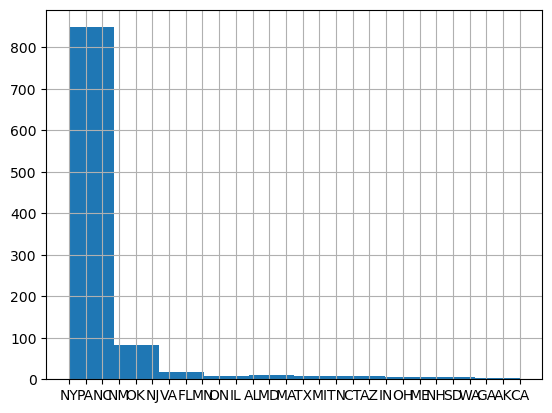

In [25]:
filtered_vehicles[:1000]['STATE_REGISTRATION'].hist()

In [26]:
state_abbreviations = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 
    'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NV', 
    'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 
    'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
] #'NE'
initial_string = "STATE_REGISTRATION_"
state_columns = []

for abbr in state_abbreviations:
    state_columns.append(initial_string + abbr)
state_columns

['STATE_REGISTRATION_AL',
 'STATE_REGISTRATION_AK',
 'STATE_REGISTRATION_AZ',
 'STATE_REGISTRATION_AR',
 'STATE_REGISTRATION_CA',
 'STATE_REGISTRATION_CO',
 'STATE_REGISTRATION_CT',
 'STATE_REGISTRATION_DE',
 'STATE_REGISTRATION_FL',
 'STATE_REGISTRATION_GA',
 'STATE_REGISTRATION_HI',
 'STATE_REGISTRATION_ID',
 'STATE_REGISTRATION_IL',
 'STATE_REGISTRATION_IN',
 'STATE_REGISTRATION_IA',
 'STATE_REGISTRATION_KS',
 'STATE_REGISTRATION_KY',
 'STATE_REGISTRATION_LA',
 'STATE_REGISTRATION_ME',
 'STATE_REGISTRATION_MD',
 'STATE_REGISTRATION_MA',
 'STATE_REGISTRATION_MI',
 'STATE_REGISTRATION_MN',
 'STATE_REGISTRATION_MS',
 'STATE_REGISTRATION_MO',
 'STATE_REGISTRATION_MT',
 'STATE_REGISTRATION_NV',
 'STATE_REGISTRATION_NH',
 'STATE_REGISTRATION_NJ',
 'STATE_REGISTRATION_NM',
 'STATE_REGISTRATION_NY',
 'STATE_REGISTRATION_NC',
 'STATE_REGISTRATION_ND',
 'STATE_REGISTRATION_OH',
 'STATE_REGISTRATION_OK',
 'STATE_REGISTRATION_OR',
 'STATE_REGISTRATION_PA',
 'STATE_REGISTRATION_RI',
 'STATE_REGI

In [27]:
filtered_vehicles['STATE_REGISTRATION'][:5]

UNIQUE_ID
19140702    NY
17044639    NY
19138701    NY
17303317    NY
17285715    NY
Name: STATE_REGISTRATION, dtype: object

### Play with KMeans for State Registration

In [28]:
dummy_set = pd.get_dummies(filtered_vehicles, columns=['STATE_REGISTRATION'])
features = state_columns
X = dummy_set[features]

In [29]:
kmeans_vehicles = KMeans(n_clusters=50)

In [30]:
kmeans_vehicles.fit(X)
dummy_set['cluster'] = kmeans_vehicles.labels_

In [31]:
print('Clusters (result of k-means)')
print(collections.Counter(kmeans_vehicles.labels_))
print(collections.Counter(filtered_vehicles['STATE_REGISTRATION']))

Clusters (result of k-means)
Counter({0: 1930518, 1: 150911, 2: 59254, 3: 30599, 4: 28530, 7: 12536, 8: 11904, 5: 11890, 6: 11302, 10: 10764, 9: 10172, 13: 9893, 12: 9756, 11: 7190, 17: 6043, 14: 5034, 19: 4658, 15: 3675, 16: 3403, 18: 3341, 24: 3072, 20: 2229, 22: 2154, 23: 1971, 31: 1697, 25: 1458, 26: 1440, 21: 1293, 27: 1181, 29: 1152, 28: 1039, 30: 901, 32: 643, 34: 638, 37: 624, 35: 623, 33: 547, 36: 482, 38: 479, 40: 457, 43: 429, 39: 400, 41: 295, 42: 253, 44: 239, 45: 173, 46: 155, 48: 68, 47: 68, 49: 63})
Counter({'NY': 1930518, 'NJ': 150911, 'PA': 59254, 'FL': 30599, 'CT': 28530, 'VA': 12536, 'MD': 11904, 'NC': 11890, 'MA': 11302, 'TX': 10764, 'IN': 10172, 'GA': 9756, 'IL': 7190, nan: 6263, 'AZ': 6043, 'SC': 5034, 'OH': 4658, 'OK': 3675, 'DE': 3403, 'CA': 3341, 'TN': 3072, 'ME': 2229, 'MI': 2154, 'RI': 1971, 'AL': 1697, 'VT': 1458, 'NH': 1440, 'NM': 1293, 'MN': 1181, 'WA': 1152, 'WI': 1039, 'ON': 903, 'MO': 901, 'PQ': 738, 'NB': 705, 'DC': 655, 'KY': 643, 'CO': 638, 'LA': 62

In [32]:
# print('labels_', kmeans_vehicles.labels_[:10])
X[:5]

,STATE_REGISTRATION_AL,STATE_REGISTRATION_AK,STATE_REGISTRATION_AZ,STATE_REGISTRATION_AR,STATE_REGISTRATION_CA,STATE_REGISTRATION_CO,STATE_REGISTRATION_CT,STATE_REGISTRATION_DE,STATE_REGISTRATION_FL,STATE_REGISTRATION_GA,STATE_REGISTRATION_HI,STATE_REGISTRATION_ID,STATE_REGISTRATION_IL,STATE_REGISTRATION_IN,STATE_REGISTRATION_IA,STATE_REGISTRATION_KS,STATE_REGISTRATION_KY,STATE_REGISTRATION_LA,STATE_REGISTRATION_ME,STATE_REGISTRATION_MD,STATE_REGISTRATION_MA,STATE_REGISTRATION_MI,STATE_REGISTRATION_MN,STATE_REGISTRATION_MS,STATE_REGISTRATION_MO,STATE_REGISTRATION_MT,STATE_REGISTRATION_NV,STATE_REGISTRATION_NH,STATE_REGISTRATION_NJ,STATE_REGISTRATION_NM,STATE_REGISTRATION_NY,STATE_REGISTRATION_NC,STATE_REGISTRATION_ND,STATE_REGISTRATION_OH,STATE_REGISTRATION_OK,STATE_REGISTRATION_OR,STATE_REGISTRATION_PA,STATE_REGISTRATION_RI,STATE_REGISTRATION_SC,STATE_REGISTRATION_SD,STATE_REGISTRATION_TN,STATE_REGISTRATION_TX,STATE_REGISTRATION_UT,STATE_REGISTRATION_VT,STATE_REGISTRATION_VA,STATE_REGISTRATION_WA,STATE_REGISTRATION_WV,STATE_REGISTRATION_WI,STATE_REGISTRATION_WY
UNIQUE_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19140702,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17044639,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
19138701,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17303317,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
17285715,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
print(filtered_vehicles['STATE_REGISTRATION'].unique())

['NY' 'PA' 'NC' 'NM' nan 'OK' 'NJ' 'VA' 'FL' 'MN' 'ON' 'IL' 'AL' 'MD' 'MA'
 'TX' 'MI' 'TN' 'CT' 'AZ' 'IN' 'OH' 'ME' 'NH' 'SD' 'WA' 'GA' 'AK' 'CA'
 'DC' 'PE' 'AR' 'DE' 'MO' 'RI' 'IA' 'UT' 'KY' 'SC' 'LA' 'NF' 'VT' 'NB'
 'MS' 'NV' 'MT' 'WI' 'CO' 'BC' 'HI' 'WV' 'PQ' 'ID' 'KS' 'WY' 'ND' 'MB'
 'OR' 'NS' 'YT' 'SK' 'AB' 'NT' 'MX' 'T' 'UA' 'LR']


In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=49)
pca.fit(X)
X_transform = pca.transform(X)

In [35]:
X_transform[:5]

array([[-1.91282805e-01, -1.54199021e-02,  4.34785680e-03,
         3.83218696e-04,  1.72743631e-03,  7.51858672e-05,
         2.57951199e-06, -8.51888279e-05, -8.83093245e-05,
        -9.26562389e-05, -6.42962587e-05, -2.23139414e-04,
        -1.66947485e-04, -1.48074678e-04, -6.42785762e-05,
        -1.24168238e-04,  4.35592204e-05, -1.12317002e-05,
        -3.27315708e-05, -7.91983677e-05, -1.35640583e-05,
        -2.59943865e-05, -3.51992559e-05, -3.27911201e-05,
        -3.28792048e-06, -1.85532997e-05, -1.64275900e-05,
        -5.07551269e-06, -1.18438875e-05, -1.36036339e-05,
        -2.35206960e-05,  8.86944448e-07,  2.06182815e-06,
        -1.82811168e-07, -7.01658903e-06, -8.16410453e-06,
        -5.48580165e-07, -2.87039300e-06, -3.38374251e-06,
        -3.18023333e-06, -6.98370083e-06, -5.77728670e-06,
        -2.35507753e-06, -7.34961953e-06,  3.04681544e-06,
         4.51717794e-06,  3.25760250e-17,  4.18863408e-07,
         3.70998187e-07],
       [-1.91282805e-01, -1.54

In [36]:
state_counts = filtered_vehicles['STATE_REGISTRATION'].value_counts()

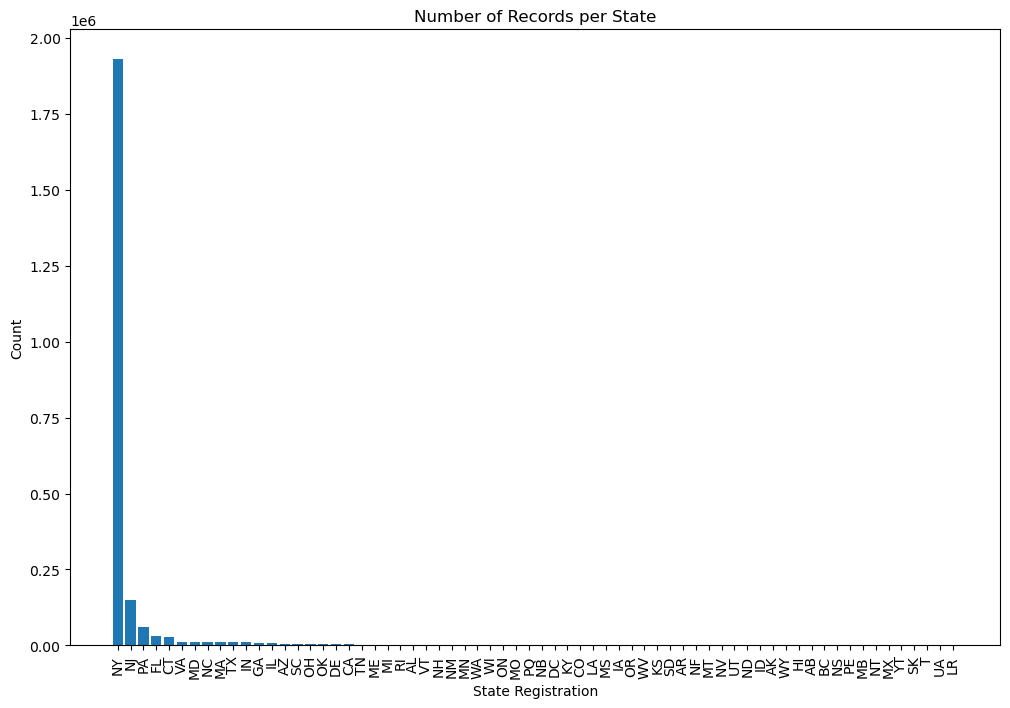

In [37]:
state_counts_df = state_counts.reset_index()
state_counts_df.columns = ['STATE_REGISTRATION', 'COUNT']

plt.figure(figsize=(12, 8))
plt.bar(state_counts_df['STATE_REGISTRATION'], state_counts_df['COUNT'])
plt.xlabel('State Registration')
plt.ylabel('Count')
plt.title('Number of Records per State')
plt.xticks(rotation=90)
plt.show()

In [38]:
# Write data back to CSV after pre-processing
filtered_vehicles.to_csv('../data/processed/vehicles_filtered.csv', index=False)

### Left TODO
* KMeans modeling of *something* of the features
    * reduce to 2 dimensions (example in crashes)
* Run a supervised learning algorithm on an already known answer 
    * Remove that column as the *ground truth* and run supervised learning
* Naive Bayes regression
* ? Determine severity by joining crashes with vehicles to add *people killed/injured* into the calculation
* More visuals?
* Add to shared report file (Teams)

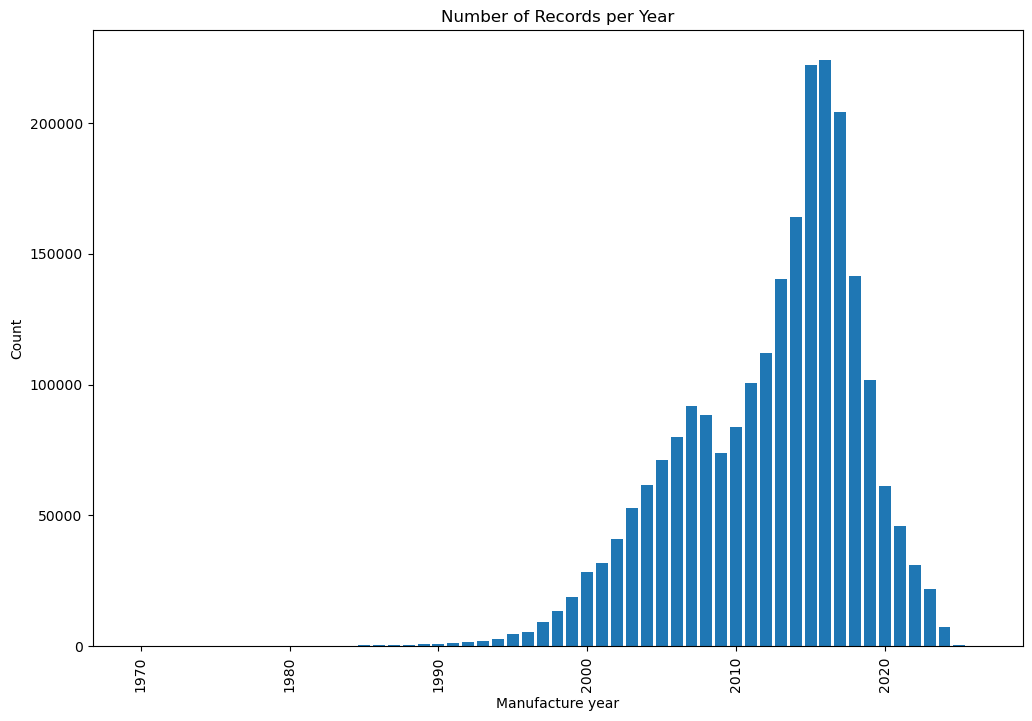

In [39]:
## Vehicle year distribution
year_counts = copy_vehicles['VEHICLE_YEAR'].value_counts()

year_counts_df = year_counts.reset_index()
year_counts_df.columns = ['VEHICLE_YEAR', 'COUNT']

plt.figure(figsize=(12, 8))
plt.bar(year_counts_df['VEHICLE_YEAR'], year_counts_df['COUNT'])
plt.xlabel('Manufacture year')
plt.ylabel('Count')
plt.title('Number of Records per Year')
plt.xticks(rotation=90)
plt.show()

### Naive Bayes Regression model

In [62]:
naive_copy = copy_vehicles.copy()
# naive_copy.dropna(inplace=True)

naive_copy.dropna(subset=['VEHICLE_OCCUPANTS'], inplace=True)

ground_truth = naive_copy['VEHICLE_YEAR']
X = naive_copy.drop(columns=[
    'VEHICLE_YEAR', 'CRASH_DATE', 'COLLISION_ID', 'VEHICLE_ID', 'CRASH_TIME',
    'DRIVER_LICENSE_JURISDICTION', 'DRIVER_LICENSE_STATUS', 'DRIVER_SEX', 'POINT_OF_IMPACT',
    'PRE_CRASH', 'PUBLIC_PROPERTY_DAMAGE_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'VEHICLE_TYPE',
    'VEHICLE_DAMAGE_1', 'VEHICLE_DAMAGE_2', 'VEHICLE_DAMAGE_3', 'CONTRIBUTING_FACTOR_2',
    'PUBLIC_PROPERTY_DAMAGE', 'CRASH_DATE_YEAR', 'CRASH_DATE_MONTH', 'CRASH_DATE_DAY'
    ])

In [63]:
bayes_vehicle_clf = BernoulliNB()
bayes_vehicle_clf.fit(X, ground_truth)

BernoulliNB()

In [71]:
print('Prediction of vehicle year: ', bayes_vehicle_clf.predict(X[-10:])) # last 5 instances
print('Ground Truth: ', ground_truth[-10:])

Prediction of vehicle year:  [2015. 2015. 2016. 2016. 2016. 2015. 2015. 2016. 2015. 2016.]
Ground Truth:  2347586    2015.0
2347587    2018.0
2347588    2021.0
2347589    2017.0
2347590    2024.0
2347591    2019.0
2347592    2017.0
2347593    2024.0
2347594    2008.0
2347595    2021.0
Name: VEHICLE_YEAR, dtype: float64


In [68]:
bayes_vehicle_clf.predict_proba(X[-2:])

array([[1.71119003e-07, 7.20584456e-07, 5.94775945e-07, 2.58421634e-07,
        7.73900341e-07, 6.44153966e-07, 3.54547897e-06, 5.94844958e-07,
        3.18065663e-06, 1.00659106e-05, 6.85072313e-06, 1.91376958e-05,
        5.66574286e-06, 5.07679406e-05, 6.46874598e-05, 1.18552588e-04,
        9.77194521e-05, 2.95483024e-04, 4.44816508e-04, 5.99501714e-04,
        6.83298156e-04, 8.55984958e-04, 6.79765476e-04, 1.04537825e-03,
        1.47081446e-03, 2.86405174e-03, 3.10189479e-03, 6.28182504e-03,
        7.81546705e-03, 1.24992413e-02, 1.72572124e-02, 1.70963903e-02,
        2.15742284e-02, 2.64403633e-02, 3.13765660e-02, 3.64381776e-02,
        4.17667282e-02, 4.52786875e-02, 3.94351025e-02, 3.10302502e-02,
        3.38373194e-02, 4.32532457e-02, 5.00026045e-02, 6.08605498e-02,
        7.72246962e-02, 9.61991616e-02, 9.10004113e-02, 7.80299766e-02,
        4.58847934e-02, 3.18377490e-02, 1.61977607e-02, 1.11707015e-02,
        8.68905302e-03, 6.70164368e-03, 2.31968124e-03, 5.868822

### Naive Bayes with Train/Test/Split

In [74]:
(X_train, X_test, y_train, y_test) = train_test_split(X, ground_truth, test_size=1/3)
print('X Shape: ', X.shape)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X Shape:  (2320311, 152)
X_train shape:  (1546874, 152)
X_test shape:  (773437, 152)


In [77]:
# train
bayes_vehicle_split_clf = BernoulliNB()
bayes_vehicle_split_clf.fit(X_train, y_train)
# predict
y_pred = bayes_vehicle_split_clf.predict(X_test)

In [81]:
# score
print("precision={}".format(metrics.precision_score(y_test, y_pred, average="weighted")))
print("recall=   {}".format(metrics.recall_score(y_test, y_pred, average="weighted")))
print("f1=       {}".format(metrics.f1_score(y_test, y_pred, average="weighted")))

c:\Users\dcalg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision=0.06422527645193428
recall=   0.09601169843180504
f1=       0.04231160454761949


In [82]:
from sklearn.model_selection import KFold

In [84]:
kf = KFold(n_splits=5, shuffle=True) # takes out one nth (5th) to test the data, and uses the rest for training
for train_index, test_index in kf.split(naive_copy):
    print("TRAIN:", train_index[:5], "TEST:", test_index[:5])
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = ground_truth.iloc[train_index], ground_truth.iloc[test_index]
    bayes_vehicle_split_clf.fit(X_train, y_train)
    y_pred = bayes_vehicle_split_clf.predict(X_test)
    print("precision={}".format(metrics.precision_score(y_test, y_pred, average="weighted")))
    print("recall=   {}".format(metrics.recall_score(y_test, y_pred, average="weighted")))
    print("f1=       {}".format(metrics.f1_score(y_test, y_pred, average="weighted")))
    
    print()
    

TRAIN: [1 2 3 4 5] TEST: [ 0  6 10 21 30]


c:\Users\dcalg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision=0.062108741765467455
recall=   0.09616797719275184
f1=       0.042351794950554335

TRAIN: [0 1 2 3 4] TEST: [ 7 12 13 27 28]


c:\Users\dcalg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision=0.06006684619753715
recall=   0.09699996983161732
f1=       0.042138805833903656

TRAIN: [0 1 2 5 6] TEST: [ 3  4 15 17 29]


c:\Users\dcalg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision=0.058063080796947934
recall=   0.09724562666195466
f1=       0.04250388424982074

TRAIN: [0 2 3 4 6] TEST: [ 1  5 11 14 18]


c:\Users\dcalg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision=0.057264047782470566
recall=   0.09606259508427753
f1=       0.04238927156037373

TRAIN: [0 1 3 4 5] TEST: [ 2  8  9 16 19]


c:\Users\dcalg\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision=0.07000464662406976
recall=   0.09613801604096005
f1=       0.0418526253719767

